## Tips vooraf:
Aan de linkerkant van dit scherm is een balk met een mapjes-icoon. Hier kan je data toevoegen en ook weer vanaf downloaden.

# Dirichlet Process Gaussian Process mixture model
In this script we try to cluster ability curves. These are curves with the index of the problem solved on the x-axis and the ability score estimate after the result of the problem at the y-axis. To cluster the ability curves we assume that they are noisy observations following different Gaussian processes with a certain mean function and kernel. Each Gaussian process corresponds to one of the clusters.
The full generative model corresponding to these texts is as follows:
$$
\require{bm}
\kappa_k \sim \text{Uniform}(0, 100) \\
\log \lambda_k \sim \mathcal{N} (0,1) \\
\log \tau_k \sim \mathcal{N} (0,1) \\
\log \ell_k \sim \mathcal{N} (0,1) \\
\log \sigma_k \sim \mathcal{N} (0,1) \\
\mu(x \mid \kappa_k, \lambda_k) = \max\left(0, \frac{2*y_{\max}}{1+\exp{-\frac{x-\kappa_k}{\lambda_k}}} -y_{\max}\right) \\
k(x, x'\mid \tau_k, \ell_k) = \tau^2_k \exp\left(-\frac{(x-x')^2}{2\ell^2_k}\right)\\
\bf{w} \sim \text{Dirichlet}(\alpha)\\
f_k \mid \kappa_k, \lambda_k, \tau_k, \ell_k \sim \text{GP}(\mu(\bf{x}\mid \kappa_k, \lambda_k), K(\bf{x}, \bf{x'}\mid \tau_k, \ell_k))\\
\bf{y}_i \mid \bf{x}_i, f_k, \sigma_k \sim \sum^K_{k=1}w_k\mathcal{MvN}(f_k(\bf{x}_i), \sigma_k I_n)
$$

# Code for setting up

In [2]:
# Install distrax to handle all the distributions. newest version breaks with necessary numpy versions.
%pip install distrax==0.1.3

# Install blackjax in a version where I understand how to generate new proposals. TODO: figure out how proposal_generator works
%pip install blackjax-nightly==0.9.6.post152

In [3]:
# Import libraries and set up settings
# Jax related libraries
import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as jrnd
from jax.nn import softmax
from jax.scipy.special import logsumexp
import jax.scipy.stats as jss
from jax.config import config
config.update("jax_enable_x64", True)  # important for practical GPs
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

#BlackJax related libraries
import blackjax as bjx
from blackjax import elliptical_slice, rmh, adaptive_tempered_smc, mala, hmc, \
                     nuts, mgrad_gaussian
import blackjax.smc.resampling as resampling
import distrax as dx

# Plotting related libraries
import matplotlib.pyplot as plt
plt.rc('axes', titlesize=22)  # fontsize of the axes title
plt.rc('axes', labelsize=20)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)  # fontsize of the tick labels
plt.rc('ytick', labelsize=14)  # fontsize of the tick labels
plt.rc('legend', fontsize=12)  # legend fontsize
plt.rc('figure', titlesize=26)  # fontsize of the figure title

# Data handling
import os
import pandas as pd
from datetime import datetime

# Miscellaneous
import sys
from google.colab import runtime, files
from tqdm import tqdm
import numpy as wrongnp
import scipy.stats as wrongss

print('Blackjax version:   ', bjx.__version__)
print('Distrax version:    ', dx.__version__)
print('Jax version:        ', jax.__version__)
print('Python version:     ', sys.version)


Blackjax version:    0.9.6.post152
Distrax version:     0.1.3
Jax version:         0.4.13
Python version:      3.10.6 (main, May 29 2023, 11:10:38) [GCC 11.3.0]


In [4]:
# Set configuration values
class Config:
    def __init__(self, configuration=None):
        if configuration is not None:
            self.config = configuration
        else:
            now = datetime.now().strftime("%Y%m%d_%H-%M-%S")
            self.config = {
                "plot_results": False,
                "save_plots": True,
                "save_plot_path": f"./plots/{now}",
                "save_results": True,
                "save_results_path": f"./results/{now}",
                "K": 19,
                "sim_K": 7,
                "prior_distributions":
                    {
                        "log_ell_dist": dx.Normal(loc=0, scale=1),
                        "log_tau_dist": dx.Normal(loc=jnp.log(2), scale=1/3.),
                        "log_sigma_dist": tfp.distributions.InverseGamma(concentration=2., scale=1/4.),
                        "log_kappa_dist": dx.Normal(loc=jnp.log(8), scale=.5),
                        "log_lambda_dist": dx.Normal(loc=jnp.log(20), scale=2),
                        "beta_dist": dx.Normal(loc=0, scale=1),
                    },
                "num_mcmc_steps": 30,
                "num_particles": 200,
                "step_sizes" : {
                        'log_ell': .01,
                        'log_tau': .01,
                        'log_sigma': .01,
                        'log_kappa': .01,
                        'log_lambda': .01,
                        'beta': .01
                    },
                "sort_on": "log_lambda",
                "now": now,
                "max_curve_items": 80,
                "with_time": True,
                "simulate": False,
                "low_mem": False,
                "kernel_func": "sqr_exp",
                "use_old_data": False,
                "pre_initialize": True,
            }
        if not os.path.exists(self.config["save_plot_path"]):
            new_dir = "./"
            for chunk in self.config["save_plot_path"].split("/"):
                new_dir += chunk + "/"
                if not os.path.exists(new_dir):
                    os.mkdir(new_dir)
        if not os.path.exists(self.config["save_results_path"]):
            new_dir = "./"
            for chunk in self.config["save_results_path"].split("/"):
                new_dir += chunk + "/"
                if not os.path.exists(new_dir):
                    os.mkdir(new_dir)

    def get(self, keyword, default=None):
        if keyword in self.config:
            return self.config[keyword]
        return default

c = Config()
plot_results = False
save_plots = False
save_plot_path = "./plots"
if not os.path.exists(save_plot_path):
    os.mkdir("./plots")
prior_distributions = c.get("prior_distributions")

# Mean and Kernel functions

In [5]:
# Define mean function and mean function helpers
def capped_sigmoid(x, offset, slope, y_max=100):
    """
    The capped sigmoid function takes in an x-value and returns the
    sigmoid value if it is part of the upper part of the sigmoid function,
    and 0 otherwise.

    Parameters
    ----------
    x : float or int
        value to transform.
    offset : float or int
        kappa value; The offset of the sigmoid function.
    slope : float or int
        lambda value; The slope of the sigmoid function.
    y-max : float or int
        The maximum value the sigmoid function can reach.

    Returns
    -------
    int or float
        sigmoid value; int only if all other values are ints.
    """
    sigmoid = 2*y_max/(1+jnp.exp(-1*(x-offset)/slope))-y_max
    return jnp.max(jnp.array([sigmoid, 0]))

def mean_array(X, offset, slope):
    """
    recursive loop over the capped sigmoid function of all X values

    Parameters:
    X: array of floats or ints
        x-values
    offset: float or int
        $\kappa$
    slope: float or int
        $\lambda$

    Returns
    -------
    array of float or int:

    """
    return jax.vmap(lambda x: capped_sigmoid(x, offset, slope))(X)


In [6]:
if c.get("kernel_func") != "abs_exp":
    # Define covariance function and helpers
    def kernel_fn(x, y, length, scale):
        """
        squared exponential kernel function for two values, commonly referred to as
        x and x'.

        Parameters:
        x: int or float array
            the x-values
        y: int or float array
            the x'-values
        length: int or float
            Parameter determining length scale of kernel; referred to as $\ell$
        scale: int or float
            Parameter determining variance in kernel; referred to as $\tau$

        Returns
        -------
        float array
            the resulting kernel.
        """
        return scale**2 * jnp.exp(-0.5 * (x-y)**2 / length**2)
else:
    def kernel_fn(x, y, length, scale):
        """
        absolute exponential kernel function for two values, commonly referred to as
        x and x'.

        Parameters:
        x: int or float array
            the x-values
        y: int or float array
            the x'-values
        length: int or float
            Parameter determining length scale of kernel; referred to as $\ell$
        scale: int or float
            Parameter determining variance in kernel; referred to as $\tau$

        Returns
        -------
        float array
            the resulting kernel.
        """
        dot_diff = (x-y)**2
        return scale**2 * jnp.exp(dot_diff / length)
#

def covariance_matrix(X, Y, length, scale, jitter=1e-6):
    """
    Recursive loop over Matrices X and X'

        Parameters:
    X: int or float matrix
        the x-values
    Y: int or float
        the x'-values
    length: int or float
        Parameter determining length scale of kernel; referred to as $\ell$
    scale: int or float
        Parameter determining variance in kernel; referred to as $\tau$

    Returns
    -------
    array of arrays of floats
        The covariance matrix.
    """
    return jax.vmap(lambda x: jax.vmap(lambda y: kernel_fn(x, y, length, scale))(Y))(X)  + jitter * jnp.eye(len(X))


# Obtain data for sampling

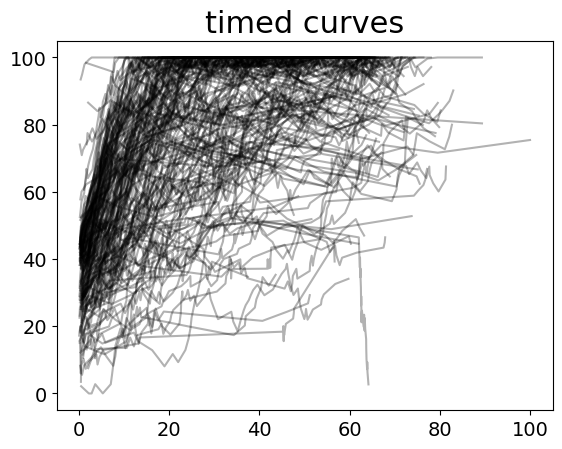

In [7]:
# Load data from files directly and extract curves if data exists, otherwise simulate it.
if os.path.exists("./elorating_all_schools.csv") \
        and os.path.exists("./exerciseresponse_all_schools.csv") \
        and not c.get("simulate") and not c.get("use_old_data"):
    # Load both sources
    elo_ratings = pd.read_csv("./elorating_all_schools.csv")
    exercise_responses = pd.read_csv("./exerciseresponse_all_schools.csv").rename(columns={"id": "_id"})

    # Combine sources on id.
    combined = pd.merge(elo_ratings, exercise_responses, on="_id", how="inner")  # how="inner" removes all items with no Eloability

    # Get identifier for each separate student/school pair.
    combined.loc[:, "stud_sch"] = combined.loc[:, "student_y"].astype(str) + combined.loc[:, "school_id_y"].astype(str)

    # Get average time spent on problem for when things are skipped
    mean_t = None
    if c.get("use_mean_for_missing"):
        mean_t = combined["timeTillAnswer"].mean()

    # read in ability curve for each student
    def get_curve(student_data, max_=100, with_time=True, mean_t=None):
        # Sort on calculation moment of ability
        data = student_data.sort_values(by=["timestamp",
                                            "rollingNoCorrectFirstAnswers",
                                            "rollingNoIncorrectFirstAnswers"])
        # Remove pre and post-test data and data after a certain time
        data = data.loc[data.isExam==False]
        data = data.loc[pd.to_datetime(data.timestamp).dt.hour < 17]
        missing_values = data[["rollingNoCorrectFirstAnswers",
                            "rollingNoIncorrectFirstAnswers"]
                            ].iloc[0].values.sum()

        # Get ability scores, scaled between 0 and 100
        y_curve = data.studentAbility.values[:max_]*25+50

        if with_time is True:
            t_data = data.timeTillAnswer.values[:max_].astype(float)
            t_curve = jnp.cumsum(jnp.array(t_data[:max_]))
            if mean_t is not None:  # Append average time to data
                t_curve+=missing_values*mean_t
        else:
            t_curve = jnp.arange(missing_values, missing_values+len(y_curve))

        return y_curve, t_curve

    Y=[]
    T=[]
    with_time = c.get("with_time")
    for student in combined.stud_sch.unique():
        y_curve, t_curve = get_curve(combined.loc[combined.stud_sch==student],
                                     mean_t = mean_t,
                                     max_=c.get("max_curve_items"),
                                     with_time=c.get("with_time"))
        Y.append(y_curve)
        T.append(t_curve)
    # Scale t to be in the range between 0 and 100:
    if with_time is True:
        max_t = max([t[-1] for t in T])/100

        T = [t/max_t for t in T]
    for y, t in zip(Y, T):
        plt.plot(t, y, c="k", alpha=.3)
    plt.title("timed curves" if with_time is True else "normal curves")
elif os.path.exists("./shortened_combined_extended.csv") and not c.get("simulate"):
    bk = pd.read_csv("./shortened_combined_extended.csv", sep="\t", index_col=0)
    bk_time = pd.read_csv("./shortened_combined_extended_time.csv", sep="\t", index_col=0)
    time_curves = bk_time.values
    time_curves = jnp.array([jnp.cumsum(time_c) for time_c in time_curves])
    Y = [curve[~jnp.isnan(curve)] for curve in bk.values]
    time_range = jnp.arange(100)
    if c.get("with_time") is True:
        T = [time_range[~jnp.isnan(curve)] for time_range, curve in zip(time_curves, bk.values)]
    else:
        T = [time_range[~jnp.isnan(curve)] for curve in bk.values]
    for y, t in zip(Y, T):
        plt.plot(t, y, c="k", alpha=.3)
    plt.title("normal curves")
else:
    K = c.get("sim_K")
    def f_sample(kf, Mu, Sigma):
        """
        sample a GP.

        Parameters
        ----------
        kf: jax.Random.PRNGKey
            key for randomness and reproducibility
        Mu: array of floats
            the mean vector; size N
        Sigma: array of arrays of floats
            The covariance matrix; size NxN
        """
        L = jnp.linalg.cholesky(Sigma)
        z = jrnd.normal(kf, shape=(Sigma.shape[0],))
        return jnp.dot(L, z) + Mu

    rng = jrnd.PRNGKey(1234)  # Set random seed.
    kr = jrnd.split(rng, 6) # Split seed in different keys, needed for randomness in JAGS, otherwise all results will be the same.

    # Set simulation true values
    true_labels = {f"log_{key}": prior_distributions[f"log_{key}_dist"]\
                        .sample(seed=kr[i], sample_shape=(K,))
                for i, key in enumerate(["ell", "tau", "sigma", "kappa", "lambda"])}
    true_labels["beta"] = prior_distributions["beta_dist"]\
                            .sample(seed=kr[5], sample_shape=(K-1,))
    ell = jnp.exp(true_labels["log_ell"])
    obs_noise = jnp.exp(true_labels["log_tau"])
    w = softmax(jnp.insert(true_labels["beta"], 0, 0, axis=0))
    tau = jnp.exp(true_labels["log_tau"])
    kappa = jnp.exp(true_labels["log_kappa"])
    lambda_ = jnp.exp(true_labels["log_lambda"])

    # Convert to log values for later use
    sim_true_log_ell = jnp.log(ell)
    sim_true_log_tau =  jnp.log(tau)
    sim_true_log_sigma =  jnp.log(obs_noise)
    sim_true_log_beta = jnp.log(w)
    sim_true_log_kappa =  jnp.log(kappa)
    sim_true_log_lambda =  jnp.log(lambda_)

    # simulate data
    ## Generate keys
    kf_, ky_, kz_ = jrnd.split(rng, 3)
    kf = jrnd.split(kf_, K)


    T_ = 100  # length of timeseries
    t = jnp.linspace(0, 99, num=T_)
    n = 40  # number of timeseries
    z = jrnd.choice(kz_, jnp.arange(K), p=jnp.asarray(w), shape=(n,))

    f = []

    ## Generate cluster means
    for k in range(K):
        Sigma_k = covariance_matrix(t, t, ell[k], tau[k])
        Mu_k = mean_array(t, kappa[k], lambda_[k])
        plt.plot(Mu_k)
        f.append(f_sample(kf[k], Mu_k, Sigma_k)) # note: for this purpose it is fine if the different f_k share the same random seed

    ## Generate observations around cluster means.
    Y = []
    ky = jrnd.split(ky_, n)
    for i in range(n):
        z_i = z[i]
        y_i = f[z_i] + obs_noise[z_i]**2*jrnd.normal(ky[i], shape=(T_,))
        Y.append(y_i)
        plt.plot(y_i, c="k", alpha=.2)
    T = [t.astype(int) for _ in Y]
if (c.get("save_plots") is True):
    plt.savefig(c.get("save_plot_path")+"/data_in.png", dpi=300)

[0.75 0.65 0.85]


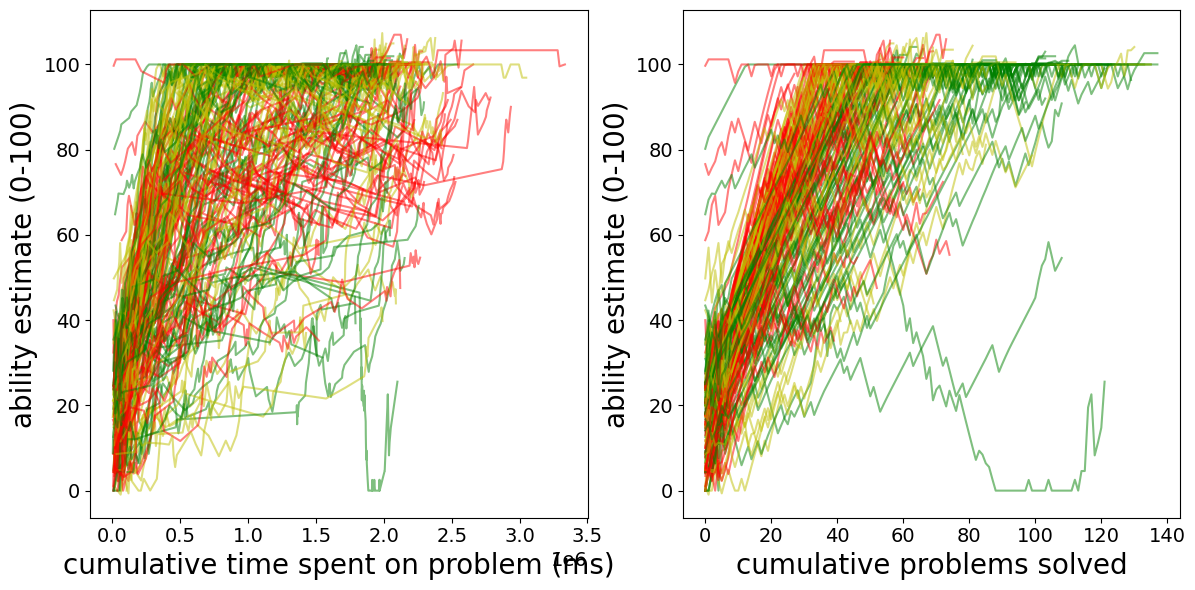

In [8]:
if os.path.exists("./elorating_all_schools.csv") \
        and os.path.exists("./exerciseresponse_all_schools.csv") \
        and not c.get("simulate"):
    # Visualize differences between time and non-time curves
    import numpy as wnp
    print(combined.difficulty_level_y.unique())
    colors = {"0.65": "r", "0.75": "y", "0.85": "g"}
    plt.figure(figsize=(12, 6))
    for student in combined.stud_sch.unique():
        student_data = combined.loc[combined.stud_sch == student]
        student_time = wnp.cumsum(wnp.array(student_data.timeTillAnswer.values.astype(float)))
        plt.subplot(1, 2, 1).plot(student_time, student_data.studentAbility.values*25+50,
                c=colors[str(student_data["difficulty_level_y"].iloc[0])], alpha=.5)
        plt.subplot(1, 2, 2).plot(student_data.studentAbility.values*25+50,
                c=colors[str(student_data["difficulty_level_y"].iloc[0])], alpha=.5)
    plt.subplot(1, 2, 1).set_xlabel("cumulative time spent on problem (ms)")
    plt.subplot(1, 2, 1).set_ylabel("ability estimate (0-100)")

    plt.subplot(1, 2, 2).set_xlabel("cumulative problems solved")
    plt.subplot(1, 2, 2).set_ylabel("ability estimate (0-100)")
    plt.tight_layout()
    plt.savefig(c.get("save_plot_path") + "/differences_time_and_problems")

# Sampler

In [9]:
# define the sampler model
class MarginalizedGPMM():

    def __init__(self, T, Y, K, sort_on=None) -> None:
        self.T = T
        self.Y = Y
        self.K = K
        self.sort_on = sort_on
        self.jmvn_logpdf = jss.multivariate_normal.logpdf

    #
    def initialize_model(self, rng_key, num_particles=1, preset_inits=None):
        """
        Get the initial parameters for the model, if we use SMC we need to
        initialize for each particle, so we need to change the shape of the
        samples. The distributions are given by the prior distributions in the
        config and the value of K is given in the initialization of the model
        (And also given in the config.)
        """
        rng_keys = jrnd.split(rng_key, 7)

        init_dists = ["log_ell", "log_tau", "log_sigma",
                      "log_kappa", "log_lambda","beta",]
        if num_particles > 1:
            init_params = {
                dist_key:
                    prior_distributions[f"{dist_key}_dist"].sample(
                        seed=rng_keys[i], sample_shape=(num_particles,
                                                       self.K
                                                       if dist_key!="beta"
                                                       else self.K-1
                                                       )
                        )
                for i, dist_key in enumerate(init_dists)
            }
        else:
            init_params = {
                dist_key:
                    prior_distributions[f"{dist_key}_dist"].sample(
                        seed=rng_keys[i], sample_shape=((self.K
                                                        if dist_key!="beta"
                                                        else self.K-1),
                                                       )
                        )
                for i, dist_key in enumerate(["log_ell",
                                              "log_tau",
                                              "log_sigma",
                                              "log_kappa",
                                              "log_lambda",
                                              "beta",
                                              ])
            }
        if preset_inits is not None:
            reset_keys = jrnd.split(rng_keys[-1], len(preset_inits))
            for rkey, (key, values) in zip(reset_keys, preset_inits.items()):
                init_params[key] = dx.Normal(0, .01).sample(
                        seed=rkey, sample_shape = init_params[key].shape
                    ) + jnp.tile(preset_inits[key],
                        (1, num_particles)).reshape(num_particles, -1)
        return init_params

    def logprior_fn(self, state):
        log_ell = state['log_ell']
        log_sigma = state['log_sigma']
        log_tau = state['log_tau']
        log_kappa = state['log_kappa']
        log_lambda = state["log_lambda"]
        beta = state['beta']

        # Remove posterior symmetry by sorting on one of the parameters
        if self.sort_on is not None:
            state[self.sort_on] = jnp.sort(state[self.sort_on])

        # get weights based on betas
        w = softmax(jnp.insert(beta, 0, 0, axis=0))  # construct [0, beta_1, ..., beta_{K-1}], to reduce symmetries in beta and hence make estimating w less stable

        log_prior = jnp.sum(jnp.array([jnp.sum(prior_distributions[f"{dist_key}_dist"].log_prob(state[dist_key]))
                                       for dist_key in ["log_ell",
                                                       "log_tau",
                                                       "log_sigma",
                                                       "log_kappa",
                                                       "log_lambda",
                                                       "beta",
                                                       ]
                             ]))
        return log_prior

    #
    def loglikelihood_fn(self, state):
        def make_cov_mat(t, log_ell_k, log_tau_k, log_sigma_k):
            return covariance_matrix(t, t, jnp.exp(log_ell_k), jnp.exp(log_tau_k)) + log_sigma_k**2 * jnp.eye(len(t))

        def make_mean_arr(t, log_kappa_k, log_lambda_k):
            return mean_array(t, jnp.exp(log_kappa_k), jnp.exp(log_lambda_k))

        log_ell = state['log_ell']
        log_sigma = state['log_sigma']
        log_tau = state['log_tau']
        log_kappa = state['log_kappa']
        log_lambda = state['log_lambda']
        beta = state['beta']

        # Remove posterior symmetry by sorting on one of the parameters
        if self.sort_on is not None:
            state[self.sort_on] = jnp.sort(state[self.sort_on])

        log_lik = 0
        w = softmax(jnp.insert(beta, 0, 0, axis=0))
        for i, t in enumerate(self.T):
            means = jax.vmap(make_mean_arr,
                             in_axes=[None, 0, 0])(t,
                                                   log_kappa,
                                                   log_lambda)
            covs = jax.vmap(make_cov_mat,
                            in_axes=[None, 0, 0, 0])(t,
                                                     log_ell,
                                                     log_tau,
                                                     log_sigma)
            def component_prob(w_k, mean_k, cov_k):
                return jnp.log(w_k) + self.jmvn_logpdf(self.Y[i], mean=mean_k, cov=cov_k)
            log_lik += logsumexp(jax.vmap(component_prob)(w, means, covs))
        return log_lik

    def logprob_fn(self, state):
        return self.logprior_fn(state) + self.loglikelihood_fn(state)

### Trying to fix mem problems


In [10]:
# define the sampler model
class FastMarginalizedGPMM():

    def __init__(self, T, Y, K, sort_on=None) -> None:
        self.T = T
        self.Y = Y
        self.K = K
        self.sort_on = sort_on
        self.jmvn_logpdf = jax.jit(jss.multivariate_normal.logpdf)
        @jax.jit
        def make_cov_mat(t, log_ell_k, log_tau_k, log_sigma_k):
            return covariance_matrix(t, t, jnp.exp(log_ell_k), jnp.exp(log_tau_k)) + jnp.exp(log_sigma_k)**2 * jnp.eye(len(t))

        @jax.jit
        def make_mean_arr(t, log_kappa_k, log_lambda_k):
            return mean_array(t, jnp.exp(log_kappa_k), jnp.exp(log_lambda_k))

        @jax.jit
        def get_comp_prob(curve, meancov):
            mean_k = meancov[0]
            cov_k = meancov[1]
            y = curve["y"]
            mvnlp = self.jmvn_logpdf(y, mean=mean_k, cov=cov_k)
            return curve, mvnlp

        self.make_cov_mat = make_cov_mat
        self.make_mean_arr = make_mean_arr
        self.get_comp_prob = get_comp_prob

    #
    def initialize_model(self, rng_key, num_particles=1):
        """
        Get the initial parameters for the model, if we use SMC we need to
        initialize for each particle, so we need to change the shape of the
        samples. The distributions are given by the prior distributions in the
        config and the value of K is given in the initialization of the model
        (And also given in the config.)
        """
        rng_keys = jrnd.split(rng_key, 6)
        init_dists = ["log_ell", "log_tau", "log_sigma",
                      "log_kappa", "log_lambda","beta",]
        if num_particles > 1:
            init_params = {
                dist_key:
                    prior_distributions[f"{dist_key}_dist"].sample(
                        seed=rng_keys[i], sample_shape=(num_particles,
                                                       self.K
                                                       if dist_key!="beta"
                                                       else self.K-1
                                                       )
                        )
                for i, dist_key in enumerate(init_dists)
            }
        else:
            init_params = {
                dist_key:
                    prior_distributions[f"{dist_key}_dist"].sample(
                        seed=rng_keys[i], sample_shape=((self.K
                                                        if dist_key!="beta"
                                                        else self.K-1),
                                                       )
                        )
                for i, dist_key in enumerate(["log_ell",
                                              "log_tau",
                                              "log_sigma",
                                              "log_kappa",
                                              "log_lambda",
                                              "beta",
                                              ])
            }
        return init_params

    def logprior_fn(self, state):
        log_ell = state['log_ell']
        log_sigma = state['log_sigma']
        log_tau = state['log_tau']
        log_kappa = state['log_kappa']
        log_lambda = state["log_lambda"]
        beta = state['beta']

        # Remove posterior symmetry by sorting on one of the parameters
        if self.sort_on is not None:
            state[self.sort_on] = jnp.sort(state[self.sort_on])

        # get weights based on betas
        w = softmax(jnp.insert(beta, 0, 0, axis=0))  # construct [0, beta_1, ..., beta_{K-1}], to reduce symmetries in beta and hence make estimating w less stable

        log_prior = jnp.sum(jnp.array([jnp.sum(prior_distributions[f"{dist_key}_dist"].log_prob(state[dist_key]))
                                       for dist_key in ["log_ell",
                                                       "log_tau",
                                                       "log_sigma",
                                                       "log_kappa",
                                                       "log_lambda",
                                                       "beta",
                                                       ]
                             ]))
        return log_prior

    #


    def loglikelihood_fn(self, state):

        log_ell = state['log_ell']
        log_sigma = state['log_sigma']
        log_tau = state['log_tau']
        log_kappa = state['log_kappa']
        log_lambda = state['log_lambda']
        beta = state['beta']

        # Remove posterior symmetry by sorting on one of the parameters
        if self.sort_on is not None:
            state[self.sort_on] = jnp.sort(state[self.sort_on])

        log_lik = 0
        w = softmax(jnp.insert(beta, 0, 0, axis=0))
        for i, t in enumerate(self.T):
            means = jax.vmap(self.make_mean_arr,
                        in_axes=[None, 0, 0])(t,
                                            log_kappa,
                                            log_lambda)
            covs = jax.vmap(self.make_cov_mat,
                    in_axes=[None, 0, 0, 0])(t,
                                                log_ell,
                                                log_tau,
                                                log_sigma)

            # Trying the scan approach (=less memory intensive)
            curve = {"y": self.Y[i]}
            mean_cov = [means, covs]
            _, mvnlp_2 = jax.lax.scan(self.get_comp_prob, curve, mean_cov)

            # Trying the basic for-loop
            # mvnlp_2 = jnp.array([])
            # for w_k, mean_k, cov_k in zip(w, means, covs):
            #     y = Y[i]

            #     mvnlp = self.jmvn_logpdf(y, mean=mean_k, cov=cov_k)
            #     mvnlp_2 = jnp.append(mvnlp_2, jnp.log(w_k) + mvnlp)

            log_lik += logsumexp(mvnlp_2)
        return log_lik

    def logprob_fn(self, state):
        return self.logprior_fn(state) + self.loglikelihood_fn(state)

In [11]:
# # Debugging differences in GPMM log_likelihoods
# t = T[0][:12]
# y = Y[0]
# @jax.jit
# def make_cov_mat(t, log_ell_k, log_tau_k, log_sigma_k):
#     return covariance_matrix(t, t, jnp.exp(log_ell_k), jnp.exp(log_tau_k)) + jnp.exp(log_sigma_k)**2 * jnp.eye(len(t))

# @jax.jit
# def make_mean_arr(t, log_kappa_k, log_lambda_k):
#     return mean_array(t, jnp.exp(log_kappa_k), jnp.exp(log_lambda_k))

# jmvn_logpdf = jax.jit(jss.multivariate_normal.logpdf)
# if "particles" in globals():
#     state = {k: v[0] for k, v in particles.particles.items()}
#     log_ell = state['log_ell']
#     log_sigma = state['log_sigma']
#     log_tau = state['log_tau']
#     log_kappa = state['log_kappa']
#     log_lambda = state['log_lambda']
#     beta = state['beta']

#     log_lik = 0
#     w = softmax(jnp.insert(beta, 0, 0, axis=0))
#     for i, t in enumerate(T[:32]):
#         means = jax.vmap(make_mean_arr,
#                             in_axes=[None, 0, 0])(t,
#                                                 log_kappa,
#                                                 log_lambda)
#         covs = jax.vmap(make_cov_mat,
#                         in_axes=[None, 0, 0, 0])(t,
#                                                     log_ell,
#                                                     log_tau,
#                                                     log_sigma)
#         covs = jnp.array([])
#         for log_ell_k, log_tau_k, log_sigma_k in zip(log_ell,
#                                                         log_tau,
#                                                         log_sigma):
#             covs = jnp.append(covs, make_cov_mat(t,
#                                                     log_ell_k,
#                                                     log_tau_k,
#                                                     log_sigma_k))
#         covs = jnp.reshape(covs, (-1, means.shape[1], means.shape[1]))


#         mvnlp_2 = jnp.array([])
#         for w_k, mean_k, cov_k in zip(w, means, covs):
#             y = Y[i]

#             mvnlp = jmvn_logpdf(y, mean=mean_k, cov=cov_k)
#             mvnlp_2 = jnp.append(mvnlp_2, jnp.log(w_k) + mvnlp)
#         log_lik += logsumexp(mvnlp_2)

#         # def component_prob(w_k, mean_k, cov_k):
#         #     return jnp.log(w_k) + jss.multivariate_normal.logpdf(Y[i], mean=mean_k, cov=cov_k)
#         # log_lik += logsumexp(jax.vmap(component_prob)(w, means, covs))

#     print(log_lik)


## Initializing means with rough k_means clustering

In [12]:
if not c.get("with_time") is True:
    # Get the curves in the correct format
    Y_with_nan = jnp.zeros(shape=(len(Y), 100)).at[:].set(jnp.nan)
    for i, (t, y) in tqdm(enumerate(zip(T, Y))):
        Y_with_nan = Y_with_nan.at[i, t].set(y)

In [97]:
means_z
# jnp.where(jnp.all(jnp.isnan(diag_dists)), 0, 1)

Array([610.23876038, 610.23876038, 610.23876038, 610.23876038,
       610.23876038, 610.23876038, 610.23876038, 610.23876038,
       610.23876038, 610.23876038, 610.23876038, 610.23876038,
       610.23876038, 610.23876038, 610.23876038, 610.23876038,
       610.23876038, 610.23876038, 610.23876038], dtype=float64)

[ 89 173 163  37  41 167  87 142  50 151 152  46 102 141 146 147 177  35
 154]


100%|██████████| 179/179 [00:07<00:00, 24.06it/s]


NameError: ignored

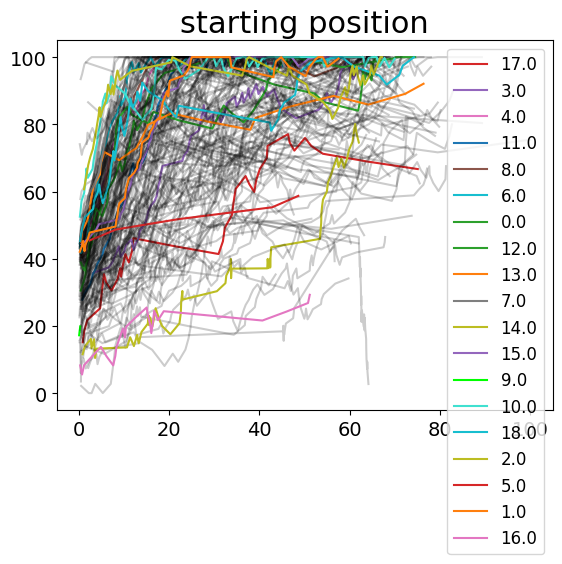

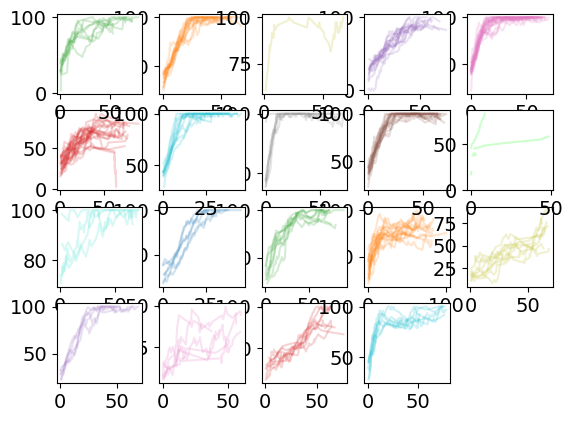

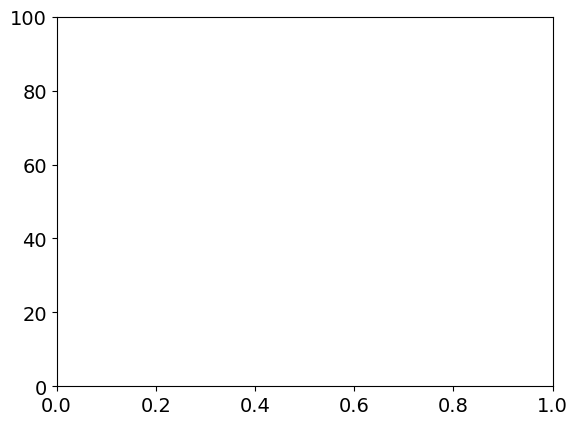

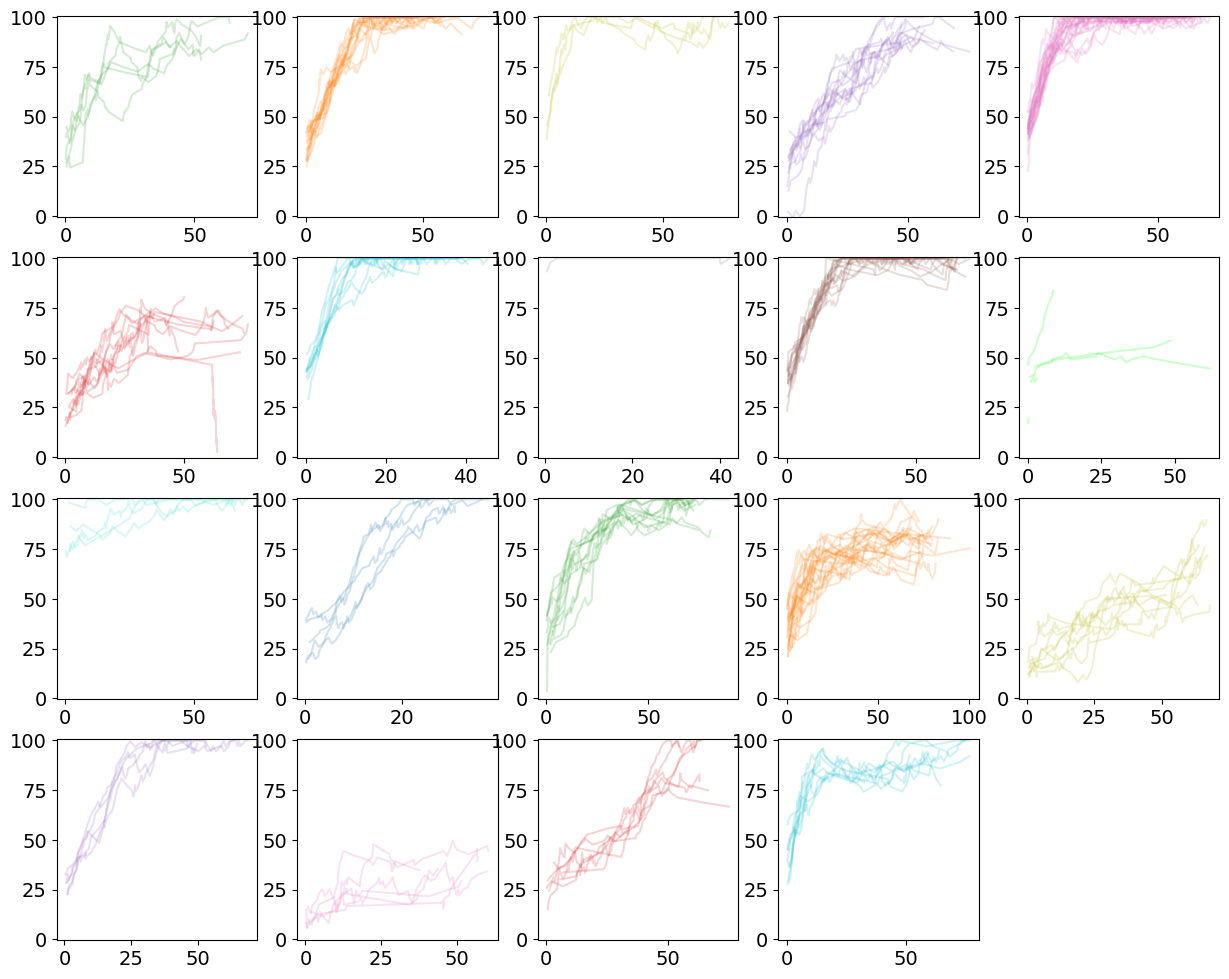

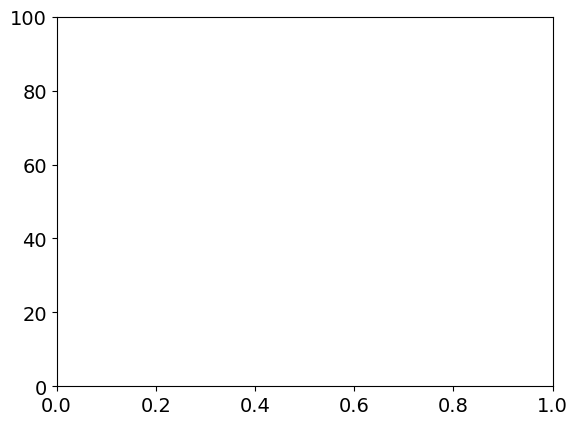

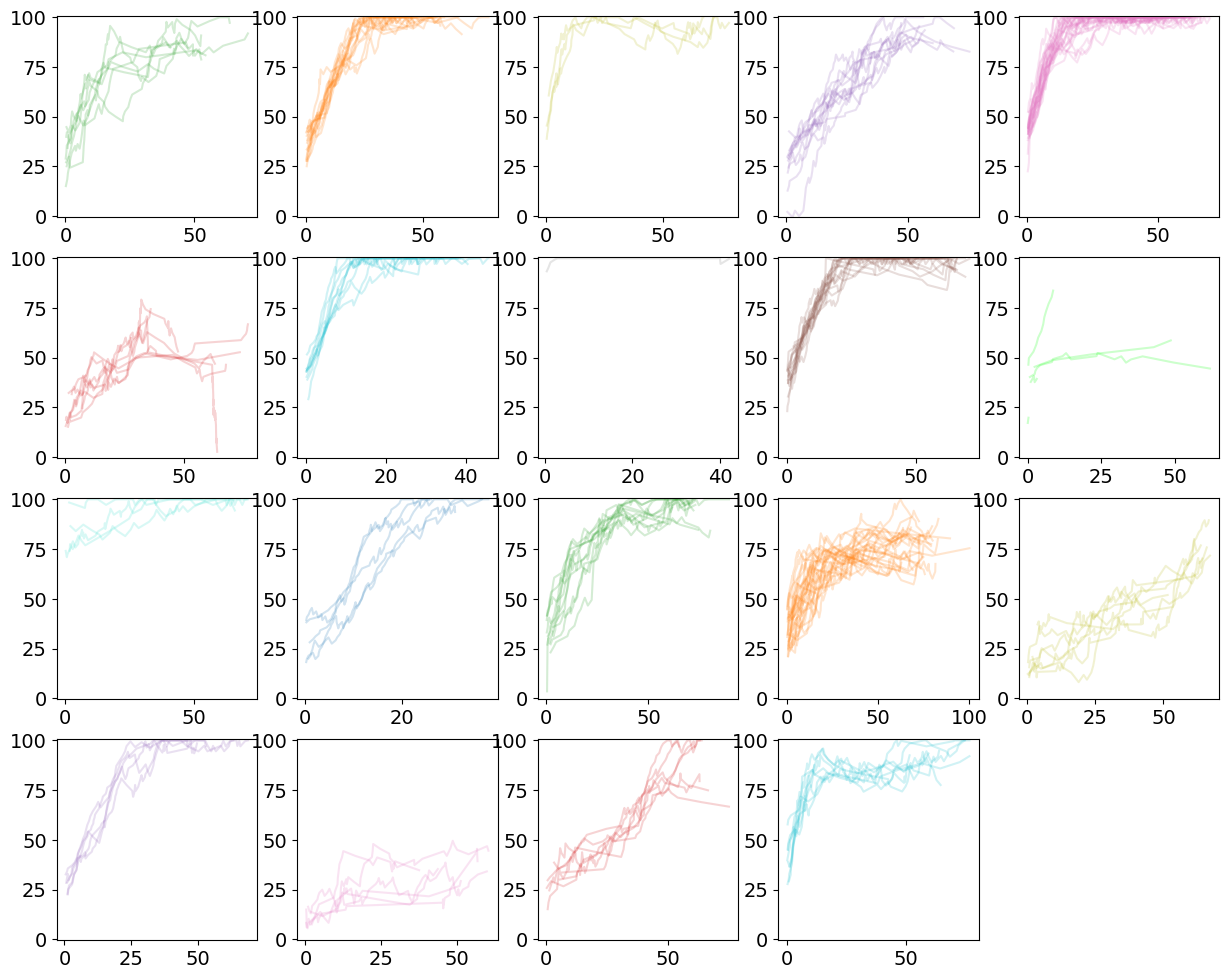

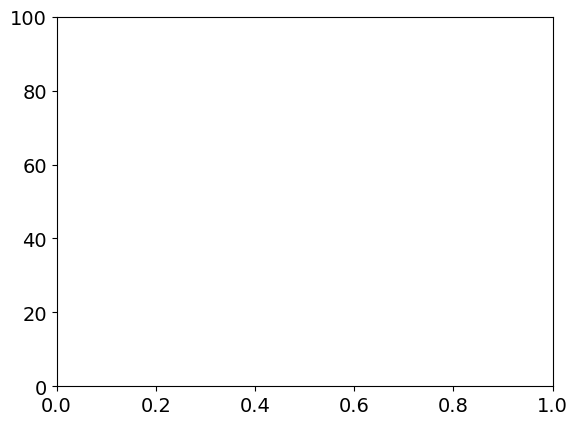

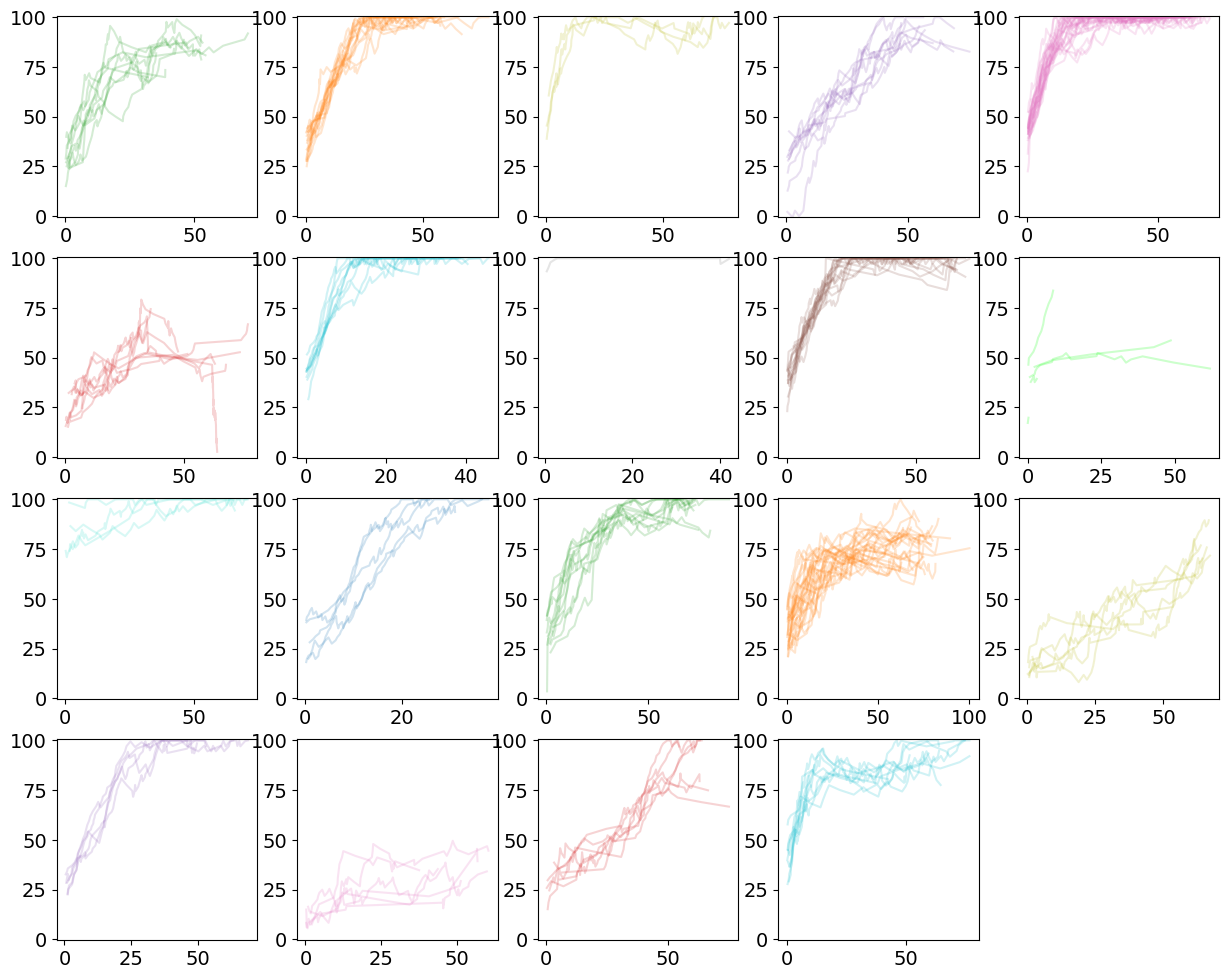

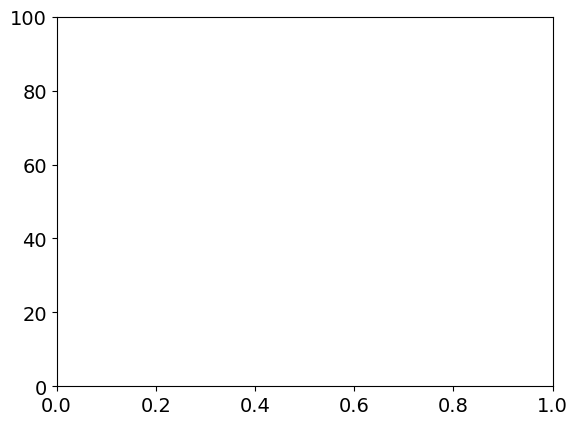

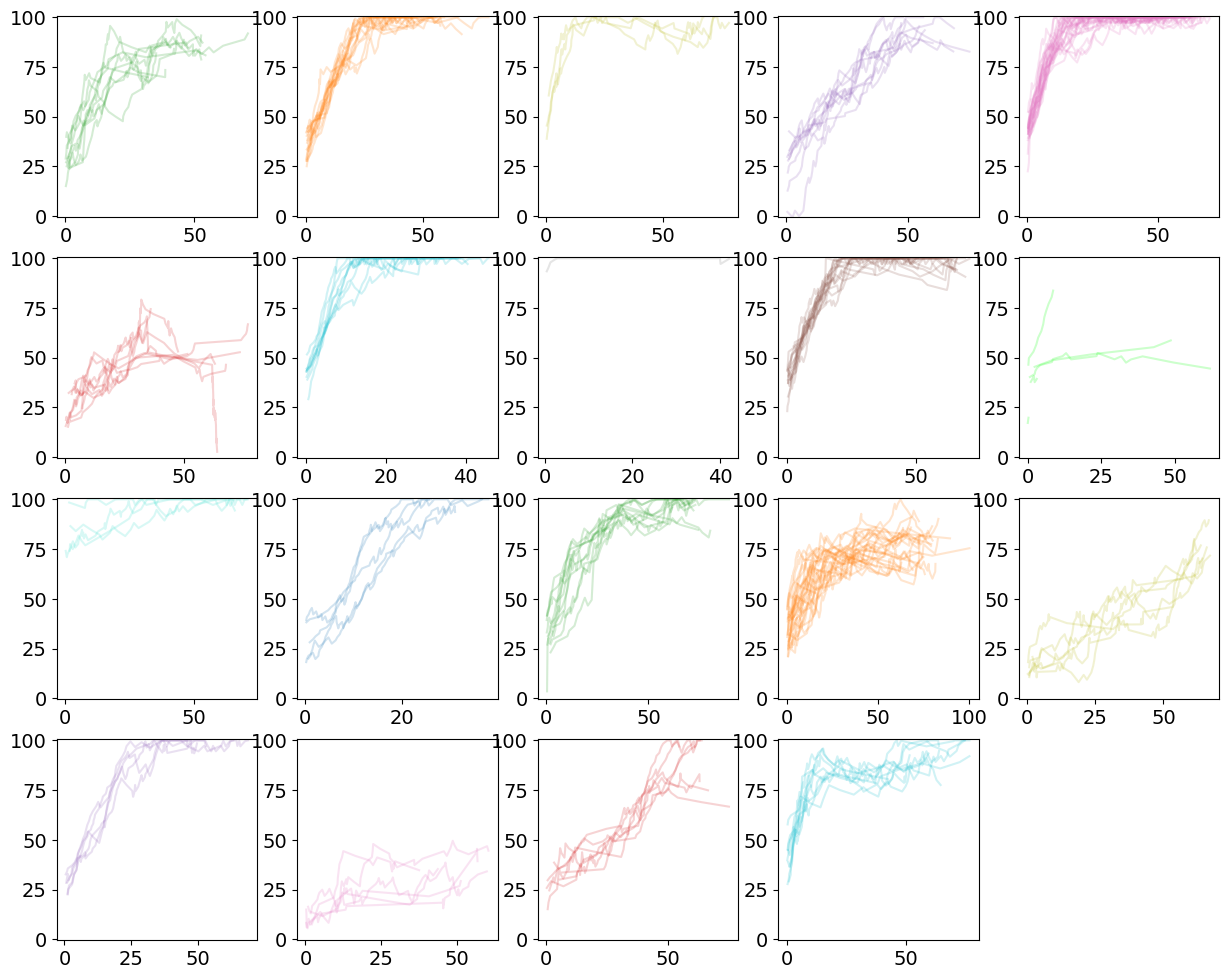

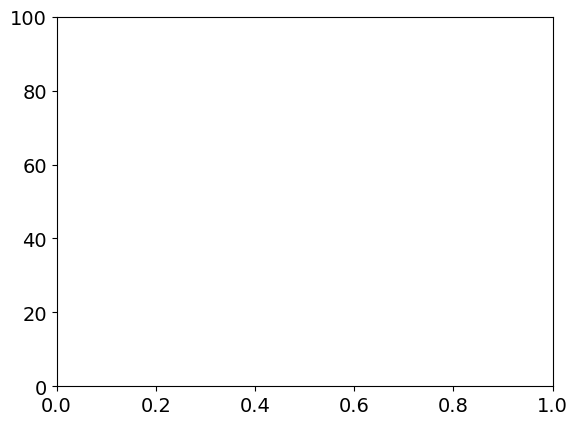

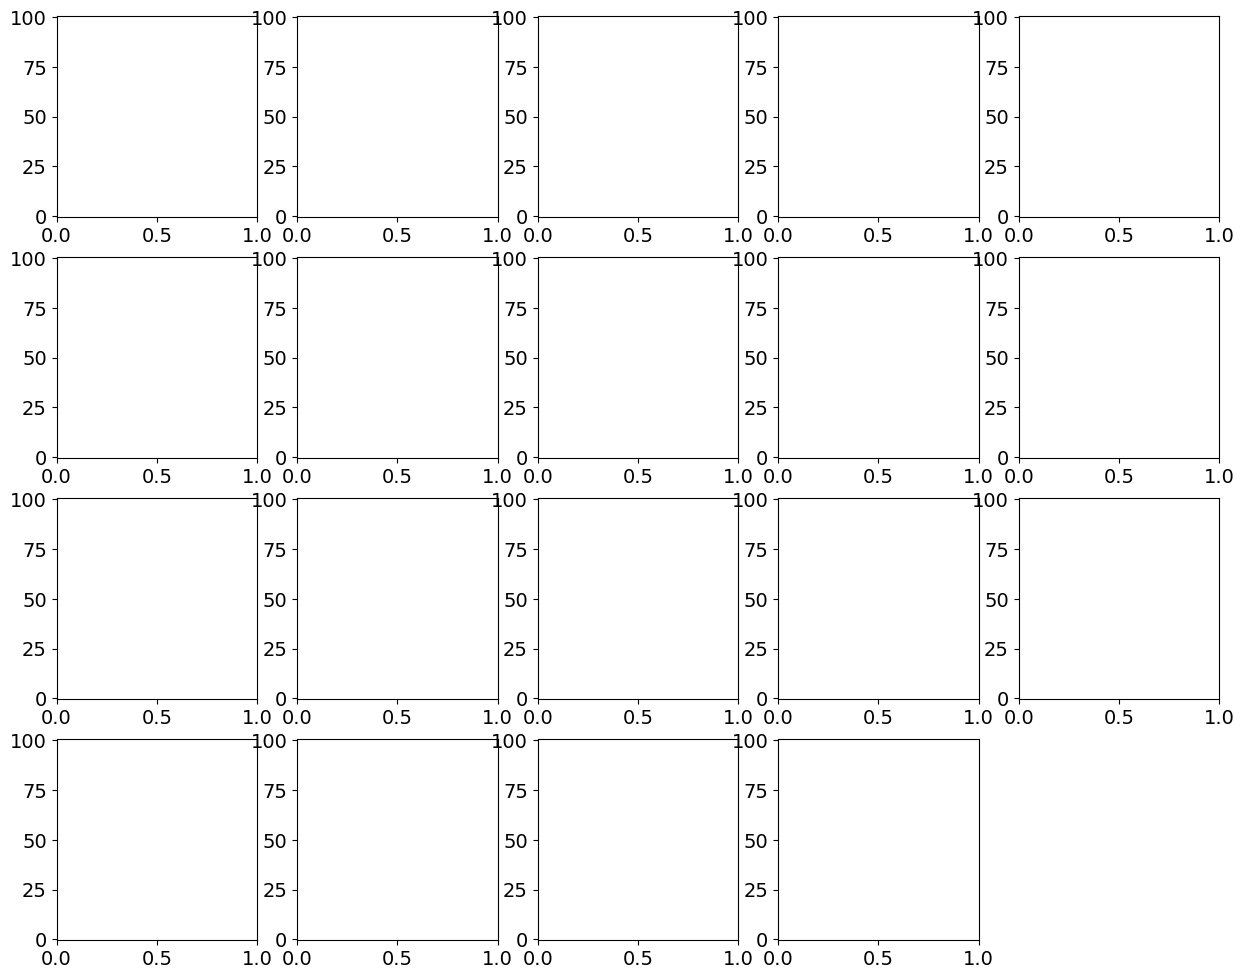

In [100]:
# Extract the k_nn like means
with_plotting = True

max_len = jnp.max(jnp.array([len(y) for y in Y]))

def get_dist(a_y, a_t, b_y, b_t):
    square_a_b = lambda a_, b_: (a_-b_)**2
    y_dists = jax.vmap((square_a_b), in_axes=(0, None))(a_y, b_y)
    t_dists = jax.vmap((square_a_b), in_axes=(0, None))(a_t, b_t)
    diag_dists = jnp.sqrt(y_dists+t_dists)
    return jnp.where(jnp.all(jnp.isnan(diag_dists)),
                     jnp.nan,
                      (jnp.nansum(jnp.nanmin(diag_dists, axis=0))
                       + jnp.nansum(jnp.nanmin(diag_dists.T, axis=0))) / 2
                     )

def get_mean_dist(curve_y, curve_t, curves_y, curves_t):
    return jnp.nanmean(jax.vmap(get_dist, in_axes=[None, None, 0, 0])(curve_y,
                                                                   curve_t,
                                                                   curves_y,
                                                                   curves_t))

# Tricks to get arrays of same size working
padded_Y = jnp.array([[jnp.nan if len(y) <= i else y[i] for i in range(max_len)] for y in Y])
padded_T = jnp.array([[jnp.nan if len(t) <= i else t[i] for i in range(max_len)] for t in T])
nans_with_len_y = jnp.zeros(len(Y)).at[:].set(jnp.nan)

# def get_dist(a, b):
#     mask = ~jnp.isnan(a)&~jnp.isnan(b)
#     a_ = jnp.where(mask, a, 0)
#     # if jnp.sum(a) <= 0:
#         # return jnp.nan
#     b_ = jnp.where(mask, b, 0)
#     distance = jnp.sum(jnp.abs(a_-b_))
#     distance = distance+jnp.sum(jnp.where(mask, 0, 1))*(jnp.mean(distance)+0.01*jnp.max(jnp.where(mask, 1, 0)))
#     return jnp.where(distance <= 0, jnp.nan, distance)

K=c.get("K")
selection = jrnd.choice(jrnd.PRNGKey(12), jnp.arange(len(Y)), shape=(K,), replace=False)
z = jnp.array([jnp.nan if c_i not in selection else jnp.where(selection==c_i)[0][0] for c_i in range(len(Y))])
print(selection)

cols = int(min(K, 5))
rows = int(K//5+1)
colors = ['tab:green', 'tab:orange', "tab:olive",
            "tab:purple", "tab:pink", "tab:red",
            "tab:cyan", "tab:gray", "tab:brown",
            "lime", "turquoise", 'tab:blue',]
cl = len(colors)
if with_plotting is True:
    for curve_i in jnp.arange(len(Y)):
        if ~jnp.isnan(z[curve_i]):
            plt.plot(T[curve_i], Y[curve_i], c=colors[int(z[curve_i])%cl], label=z[curve_i])
        else:
            plt.plot(T[curve_i], Y[curve_i], c="k", alpha=.2)

    plt.legend()
    plt.title("starting position")
    plt.figure()

z_olds = jnp.array([z.copy()])

for i in range(5):  # Do a maximum of 50 loops
    new_z = z.copy()
    for curve_i in tqdm(range(len(Y))):
        curve_y = Y[curve_i]
        curve_t = T[curve_i]
        means_z = jax.vmap((lambda z_: get_mean_dist(
                curve_y,
                curve_t,
                jnp.where(jnp.repeat((z_ == new_z), 80).reshape(-1, 80), padded_Y, jnp.tile(jnp.nan, (179, 80))),
                jnp.where(jnp.repeat((z_ == new_z), 80).reshape(-1, 80), padded_T, jnp.tile(jnp.nan, (179, 80)))
            )))(jnp.arange(K))

        # for z_ in range(K):
        #     Y_z = jnp.array([y_ for y_, y_z in zip(padded_Y, z) if y_z == z_])
        #     T_z = jnp.array([t_ for t_, t_z in zip(padded_T, z) if t_z == z_])
        #     means_z.append(get_mean_dist(curve_y, curve_t, Y_z, T_z))
        new_z = new_z.at[curve_i].set(jnp.argmin(means_z))
        if with_plotting is True:
            plt.subplot(rows, cols, int(new_z[curve_i])+1).plot(curve_t, curve_y, c=colors[int(new_z[curve_i])%cl], alpha=.2)
    z = new_z
    if with_plotting is True:
        plt.figure()
        plt.ylim([0, 100])
    # for m_i in range(len(means)):
    #     m_i_curves = Y_with_nan[z==m_i]
    #     if len(m_i_curves) > 0:
    #         means = means.at[m_i].set(jnp.nanmean(m_i_curves, axis=0))
    #     else:
    #         means = means.at[m_i].set(jnp.array([jnp.nan for _ in jnp.arange(100)]))
    #     if with_plotting is True:
    #         plt.plot(means[m_i], c=colors[m_i%cl])
    if with_plotting is True:
        plt.figure(figsize=(3*cols, 3*rows))
        for k in range(K):
            plt.subplot(rows, cols, k+1).set_ylim([-.5, 100.5])
    if jnp.any(jax.vmap(lambda z_old: jnp.all(new_z==z_old))(z_olds)):
        break
    z_olds = jnp.append(z_olds, new_z.copy()).reshape(-1, len(z))

for curve_i in range(len(Y)):
    plt.subplot(rows, cols, int(z[curve_i])+1).set_ylim([-.5, 100.5])
    plt.subplot(rows, cols, int(z[curve_i])+1).plot(Y_with_nan[curve_i], c=colors[int(z[curve_i])%cl], alpha=.2)


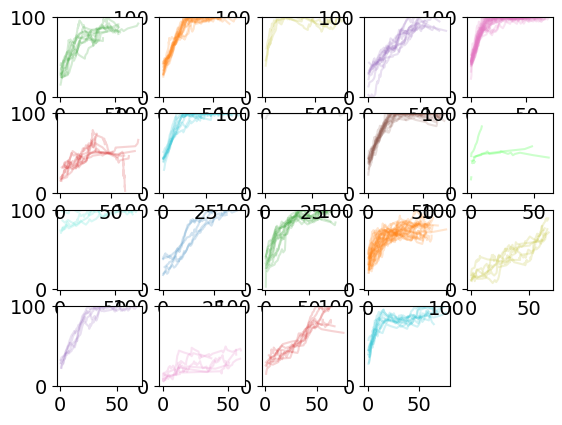

In [102]:
for curve_i in range(len(Y)):
    plt.subplot(rows, cols, int(z[curve_i])+1).set_ylim([-.5, 100.5])
    plt.subplot(rows, cols, int(z[curve_i])+1).plot(T[curve_i], Y[curve_i], c=colors[int(z[curve_i])%cl], alpha=.2)


In [ ]:
# Get the correct values for the means
X = jnp.arange(100)
lowest_kappas = []
lowest_lambdas = []
for z_ in range(K):
    z_y = padded_Y[z_==z]
    z_t = padded_T[z_==z]
    if with_plotting is True:
        plt.subplot(rows, cols, z_+1).plot(z_t.T, z_y.T)
        plt.subplot(rows, cols, z_+1).set_ylim([-.5, 100.5])
    sigmoids = {}
    distances = {}
    lowest_lambda = None
    lowest_kappa = 10
    for pass_ in range(4):
        lambda_min = 0.1
        lambda_max = 1000

        kappa_min = 0.01
        kappa_max = 100
        for use_kappa in [False, True]:
            for i in range(10):
                if use_kappa:
                    kappa_values = jnp.linspace(kappa_min, kappa_max, 10)
                    lambda_values = [lowest_lambda]
                else:
                    lambda_values = jnp.linspace(lambda_min, lambda_max, 10)
                    kappa_values = [lowest_kappa]
                lowest_dist = 9999999
                for kappa in kappa_values:
                    for lambda_ in lambda_values:
                        sigmoids[f"{kappa}_{lambda_}"] = mean_array(X, kappa, lambda_)
                        distance = get_mean_dist(sigmoids[f"{kappa}_{lambda_}"], X, z_y, z_t)
                        distances[f"{kappa}_{lambda_}"] = distance
                        if distance < lowest_dist:
                            lowest_dist = distance
                            lowest_kappa = kappa
                            lowest_lambda = lambda_
                            if use_kappa:
                                ki = jnp.where(kappa_values == kappa)[0][0]
                            else:
                                li = jnp.where(lambda_values == lambda_)[0][0]
                print(f"lowest dist for mean {z_} is", lowest_dist, end=" ")
                print(f"for offset of {kappa} and slope of {lambda_}")
                if with_plotting is True:
                    plt.subplot(rows, cols, z_+1).plot(sigmoids[f"{kappa}_{lambda_}"])
                if use_kappa is False:
                    if li < 4:
                        lambda_min = lambda_values[0]
                        lambda_max = lambda_values[4]
                    elif li > len(lambda_values)-4:
                        lambda_min = lambda_values[-5]
                        lambda_max = lambda_values[-1]
                    else:
                        lambda_min = lambda_values[li-2]
                        lambda_max = lambda_values[li+2]
                else:
                    if ki < 4:
                        kappa_min = kappa_values[0]
                        kappa_max = kappa_values[4]
                    elif ki > len(kappa_values)-4:
                        kappa_min = kappa_values[-5]
                        kappa_max = kappa_values[-1]
                    else:
                        kappa_min = kappa_values[ki-2]
                        kappa_max = kappa_values[ki+2]
    lowest_kappas.append(lowest_kappa)
    lowest_lambdas.append(lowest_lambda)
plt.figure()
for z_ in range(K):
    plt.subplot(rows, cols, z_+1).plot(padded_T[z_==z].T, padded_Y[z_==z].T, c="k", alpha=.3)
    plt.subplot(rows, cols, z_+1).set_ylim([-.5, 100.5])
    plt.subplot(rows, cols, z_+1).plot(mean_array(X, lowest_kappas[z_], lowest_lambdas[z_]), c="grey")

lowest dist for mean 0 is 1952.9540322440605 for offset of 10 and slope of 1000.0
lowest dist for mean 0 is 1952.9540322440605 for offset of 10 and slope of 444.49999999999994
lowest dist for mean 0 is 1695.8243760812848 for offset of 10 and slope of 197.61111111111106
lowest dist for mean 0 is 1319.7491570466723 for offset of 10 and slope of 87.8827160493827
lowest dist for mean 0 is 1319.0186433826566 for offset of 10 and slope of 39.114540466392306
lowest dist for mean 0 is 1319.5109713460715 for offset of 10 and slope of 17.439795762841026
lowest dist for mean 0 is 1318.295865577003 for offset of 10 and slope of 13.586507815543019
lowest dist for mean 0 is 1318.3441672457063 for offset of 10 and slope of 11.017649184011015
lowest dist for mean 0 is 1318.3431037812786 for offset of 10 and slope of 9.875934236663458
lowest dist for mean 0 is 1318.2983453815457 for offset of 10 and slope of 9.368505371175655
lowest dist for mean 0 is 1148.3896443856506 for offset of 100.0 and slope of

#Do the sampling

In [ ]:
# %%time
# Define the logic to start sampling
def smc_inference_loop(rng_key, smc_kernel, initial_state):
    """The sequential Monte Carlo loop.

    Args:
        key:
            The jax.random.PRNGKey
        smc_kernel:
            The SMC kernel object (e.g. SMC, tempered SMC or
                    adaptive-tempered SMC)
        initial_state:
            The initial state for each particle
    Returns:
        n_iter: int
            The number of tempering steps
        final_state:
            The final state of each of the particles
        info: SMCinfo
            the SMC info object which contains the log marginal likelihood of
              the model (for model comparison)

    """

    @jax.jit
    def cond(carry):
        _, state, *_k = carry
        # jax.clear_caches()
        return state.lmbda < 1

    #
    @jax.jit
    def one_step(carry):
        i, state, k, curr_log_likelihood = carry
        k, subk = jax.random.split(k, 2)
        state, info = smc_kernel(subk, state)
        return i + 1, state, k, curr_log_likelihood + info.log_likelihood_increment

    #
    n_iter, final_state, _, info = jax.lax.while_loop(cond, jax.jit(one_step),
                                                      (0, initial_state, rng_key, 0))
    return n_iter, final_state, info

# Set parameters for sampling
sort_on = c.get("sort_on")
K = c.get("K")
if c.get("low_mem"):
    mgpmm = FastMarginalizedGPMM(T=T, Y=Y, K=K, sort_on=sort_on)
else:
    mgpmm = MarginalizedGPMM(T=T, Y=Y, K=K, sort_on=sort_on)

key = jrnd.PRNGKey(42)
key_init, key_smc = jrnd.split(key, 2)

# Set smc stepsize for all latent variables, store in mcmc_parameters.
step_sizes = c.get("step_sizes")
initial_particles = mgpmm.initialize_model(key_init)
sigmas = []
for key in initial_particles.keys():
    for i in range(len(initial_particles[key].flatten())):
        sigmas.append(step_sizes[key])
mcmc_parameters = dict(sigma=jnp.eye(len(sigmas)) * jnp.array(sigmas))

# Set up the smc sampler.
smc = adaptive_tempered_smc(mgpmm.logprior_fn,
                            mgpmm.loglikelihood_fn,
                            bjx.rmh.kernel(),
                            bjx.rmh.init,
                            mcmc_parameters,
                            resampling.systematic,
                            0.5,
                            num_mcmc_steps=c.get("num_mcmc_steps")
                            )

num_particles = c.get("num_particles")

# Set initial particles
preset_inits = None
if c.get("pre_initialize") is True:
    preset_inits = {"log_lambda": jnp.log(jnp.array(lowest_lambdas)),
                    "log_kappa": jnp.log(jnp.array(lowest_kappas))}
initial_particles = mgpmm.initialize_model(key_init,
                                           num_particles=num_particles,
                                           preset_inits=preset_inits)
initial_smc_state = smc.init(initial_particles) # We need to initialize SMC with a dictionary

# Do the actual sampling
num_iter, particles, marginal_likelihood = smc_inference_loop(key_smc,
                                                                smc.step,
                                                                initial_smc_state)

# Retrieve sample values
ell_samples = jnp.exp(particles.particles['log_ell'])
sigma_samples = jnp.exp(particles.particles['log_sigma'])
tau_samples = jnp.exp(particles.particles['log_tau'])
kappa_samples = jnp.exp(particles.particles['log_kappa'])
lambda_samples = jnp.exp(particles.particles['log_lambda'])
beta_samples = particles.particles['beta']
w_samples = jax.vmap(softmax)(jnp.column_stack( (jnp.zeros((num_particles, 1)), beta_samples) ))
colors = ["lime", "turquoise", 'tab:blue',
          'tab:green', 'tab:orange', "tab:olive",
          "tab:purple", "tab:pink", "tab:red",
          "tab:cyan", "tab:gray", "tab:brown",]

In [ ]:
# Download samples
now = c.get("now")
samples_dict = dict(ell_samples=ell_samples,
                    sigma_samples=sigma_samples,
                    tau_samples=tau_samples,
                    kappa_samples=kappa_samples,
                    lambda_samples=lambda_samples,
                    beta_samples=beta_samples,
                    w_samples=w_samples,
                    )

for key, state in samples_dict.items():
    pd.DataFrame(state).to_csv(f"{key}_{now}.csv")
    files.download(f"{key}_{now}.csv")

    print(key, ": ", state.shape)

In [ ]:
y_non_jags = [list(y) for y in Y]
K=c.get("K")

In [ ]:
# Show clusters for the mean value of the samples
def f_sample(kf, Mu, Sigma):
    """
    Function to show posterior predictions of curves belonging to the cluster
    """
    L = jnp.linalg.cholesky(Sigma)
    z = jrnd.normal(kf, shape=(Sigma.shape[0],))
    return jnp.dot(L, z) + Mu

# Create subplot figure
n_rows = 1+(K)//5
n_cols = min(K, 5)
f, a = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))

# For each cluster, show the observed curves on the background, the cluster
# mean, a confidence interval of two standard deviations around the cluster
# and some predicted samples of the cluster.
T_range = jnp.arange(100)
for k in range(K):
    ax = a.flatten()[k]
    ax.set_ylim(-5, 105)
    mean_k = mean_array(T_range,  # Obtain cluster mean
                        jnp.mean(kappa_samples, axis=0)[k],
                        jnp.mean(lambda_samples, axis=0)[k])
    sigma_k = covariance_matrix(T_range, T_range,  # Obtain cluster kernel
                                jnp.mean(ell_samples, axis=0)[k],
                                jnp.mean(tau_samples, axis=0)[k])
    k_variance = 2*jnp.sqrt(jnp.diag(sigma_k)+jnp.mean(sigma_samples, axis=0)[k]**2)  # obtain cluster variance

    # Plot cluster variance
    ax.fill_between(T_range,
                    mean_k+2*k_variance,
                    mean_k-2*k_variance,
                    alpha=.5,
                    color=colors[k%len(colors)])

    # Plot observed curves on background
    for i, (t, y) in enumerate(zip(T, y_non_jags)):
        ax.plot(t, y, alpha = .3, c="k")

    # Get and plot posterior predicted observations
    kf = jrnd.split(jrnd.PRNGKey(432), 11)
    ax.plot(T_range, mean_k, c=colors[k%len(colors)], alpha=.8)
    for i in range(10):
        ax.plot(f_sample(kf[i], mean_k, sigma_k), color=colors[k%len(colors)], alpha=.5)
    a.flatten()[-1].bar([k], [float(jnp.mean(w_samples, axis=0)[k])], color=colors[k%len(colors)], label=k)
a.flatten()[-1].legend()


In [ ]:
## Testing whether the two models have the same results and whether one
## is faster than the other.
# mpgmm_1 = MarginalizedGPMM(T=T, Y=Y, K=K, sort_on=sort_on)
# mpgmm_2 = FastMarginalizedGPMM(T=T, Y=Y, K=K, sort_on=sort_on)
# for i, m in enumerate([mpgmm_1, mpgmm_2]):
#     print(i)
#     print(m.loglikelihood_fn({k: v[0] for k, v in particles.particles.items()}))

In [ ]:
# Upload samples, in case of disconnection
samples_dict = dict(
    ell_samples=None,
    sigma_samples=None,
    kappa_samples=None,
    lambda_samples=None,
    beta_samples=None,
    w_samples=None,
    tau_samples=None)
for key in samples_dict.keys():
    samples_dict[key] = pd.read_csv([file for file in os.listdir("./") if key in file][0], index_col=0)
ell_samples=samples_dict["ell_samples"].values
sigma_samples=samples_dict["sigma_samples"].values
tau_samples=samples_dict["tau_samples"].values
kappa_samples=samples_dict["kappa_samples"].values
lambda_samples=samples_dict["lambda_samples"].values
beta_samples=samples_dict["beta_samples"].values
w_samples=samples_dict["w_samples"].values
colors = ["lime", "turquoise", 'tab:blue',
          'tab:green', 'tab:orange', "tab:olive",
          "tab:purple", "tab:pink", "tab:red",
          "tab:cyan", "tab:gray", "tab:brown",]

In [ ]:
plt.figure(figsize=(18, 12))
for k in range(min(9, sigma_samples.shape[1])):
    plt.subplot(3, 3, k+1).hist(sigma_samples[:,k])

Inspect SMC result

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(25, 5+1.7), ncols=6, gridspec_kw={'height_ratios': [6, 1]},
                         constrained_layout=True)
axes = axes.flatten()
def plot_samples(ax, samples, title, color):
    ax.set_title(title)
    return ax.scatter(jnp.arange(len(samples)), samples, color=color)

colors = ["lime", "turquoise", 'tab:blue',
          'tab:green', 'tab:orange', "tab:olive",
          "tab:purple", "tab:pink", "tab:red",
          "tab:cyan", "tab:gray", "tab:brown",]
l = [0 for _ in range(K)]
lc = len(colors)
for k in range(K):
    l[k] = plot_samples(axes[0], ell_samples[:, k], r"$\ell_k$", colors[k%lc])
    plot_samples(axes[1], tau_samples[:, k], r'$\tau_k$', colors[k%lc])
    plot_samples(axes[2], sigma_samples[:, k], r"$\sigma_k$", colors[k%lc])
    plot_samples(axes[3], kappa_samples[:, k], r"$\kappa_k$", colors[k%lc])
    plot_samples(axes[4], lambda_samples[:, k], r"$\lambda_k$", colors[k%lc])
    plot_samples(axes[5], jnp.reshape(w_samples, (w_samples.shape[0], -1))[:, k], "$w_k$", colors[k%lc])



for ax in axes[6:]:
    ax.axis("off")

axes[8].legend(l, [str(_) for _ in range(K)], ncol=min(K,4))
# axes[6].axis("off")
plt.suptitle('scatter plots (AT-SMC)')

## Get overview of posterior log probability for each particle

In [ ]:
# Retrieve what probability of labels for each curve.
%%time
# Do a jax scan over all samples.
# Give an initial state with what we want as output
#  and with things necessary each step
init = {"Y": Y, "T": T}
xs = [ell_samples, tau_samples, sigma_samples, kappa_samples, lambda_samples, w_samples]

def get_unnorm_probs(carry, x):
    def make_mean_arr(t, kappa_k, lambda_k):
        return mean_array(t, kappa_k, lambda_k)

    def make_cov_mat(t, tau_k, ell_k, sigma_k):
        return covariance_matrix(t, t, ell_k,
                                 tau_k
                                 ) + sigma_k**2 * jnp.eye(len(t))

    def component_prob(y, t, w_k, kappa_k, lambda_k, tau_k, ell_k, sigma_k):
        return jnp.log(w_k) + jss.multivariate_normal.logpdf(
            y,
            mean=make_mean_arr(t, kappa_k, lambda_k),
            cov=make_cov_mat(t, tau_k, ell_k, sigma_k)
            )

    Y = carry["Y"]
    T = carry["T"]
    ell_s = x[0]  # ell
    tau_s = x[1]  # tau
    sigma_s = x[2]  # sigma
    kappa_s = x[3]  # kappa
    lambda_s = x[4]  # lambda
    w_s = x[5]  # w

    print(w_s.shape)
    unnorm_log_probs_s = []
    norm_probs_s = []

    for y, t in zip(Y, T):
        unnorm_log_probs_i = jax.vmap(component_prob,
                                      in_axes=[None, None, 0, 0, 0, 0, 0, 0]
                                      )(y, t, w_s, kappa_s, lambda_s, tau_s,
                                        ell_s, sigma_s)
        norm_log_probs_i = unnorm_log_probs_i - logsumexp(unnorm_log_probs_i)
        norm_probs_s.append(jnp.exp(norm_log_probs_i))
        unnorm_log_probs_s.append(logsumexp(unnorm_log_probs_i))
    return carry, {"unnorm_probs_s": unnorm_log_probs_s,
                   "norm_probs_s": norm_probs_s}



_, probs = jax.lax.scan(get_unnorm_probs, init, xs)
print([f"{k}: {v[:100]}" for k, v in probs.items()])

In [ ]:
unnorm_log_probs = jnp.array(probs["unnorm_probs_s"])
post_prob_per_particle = jnp.sum(unnorm_log_probs, axis=(0))
best_particle = jnp.argmax(post_prob_per_particle)
print(f"best particle is {best_particle}")


In [ ]:
# Show clusters for the best particle of the samples
def f_sample(kf, Mu, Sigma):
    """
    Function to show posterior predictions of curves belonging to the cluster
    """
    L = jnp.linalg.cholesky(Sigma)
    z = jrnd.normal(kf, shape=(Sigma.shape[0],))
    return jnp.dot(L, z) + Mu

# Create subplot figure
n_rows = 1+(K)//5
n_cols = min(K, 5)
f, a = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))

# For each cluster, show the observed curves on the background, the cluster
# mean, a confidence interval of two standard deviations around the cluster
# and some predicted samples of the cluster.
T_range = jnp.arange(100)
for k in range(K):
    ax = a.flatten()[k]
    ax.set_ylim(-5, 105)
    mean_k = mean_array(T_range,  # Obtain cluster mean
                        kappa_samples[best_particle, k],
                        lambda_samples[best_particle, k])
    sigma_k = covariance_matrix(T_range, T_range,  # Obtain cluster kernel
                                ell_samples[best_particle, k],
                                tau_samples[best_particle, k])
    k_variance = 2*jnp.sqrt(jnp.diag(sigma_k)+jnp.exp(sigma_samples[best_particle, k])**2)  # obtain cluster variance

    # Plot cluster variance
    ax.fill_between(T_range,
                    mean_k+2*k_variance,
                    mean_k-2*k_variance,
                    alpha=.5,
                    color=colors[k%lc])

    # Plot observed curves on background
    for i, (t, y) in enumerate(zip(T, y_non_jags)):
        ax.plot(t, y, alpha = .3, c="k")

    # Get and plot posterior predicted observations
    kf = jrnd.split(jrnd.PRNGKey(432), 11)
    ax.plot(T_range, mean_k, c=colors[k%lc], alpha=.8)
    for i in range(10):
        ax.plot(f_sample(kf[i], mean_k, sigma_k), color=colors[k%lc], alpha=.5)
    a.flatten()[-1].bar([k], [float(w_samples[best_particle, k])], color=colors[k%lc], label=k)
a.flatten()[-1].legend()


In [ ]:
# Show probability per student (y axis) and per cluster (x-axis). More yellow is more probability.
norm_probs = jnp.array(probs["norm_probs_s"])
plt.figure( figsize=(16, 12))
plt.subplot(1,2,1).imshow(jnp.mean(norm_probs, axis=(1)))
plt.subplot(1,2,2).imshow(norm_probs[:, best_particle])


In [ ]:
plt.scatter(jnp.arange(c.get("K")), jnp.mean(norm_probs[:, best_particle], axis=0))

In [ ]:
cluster_alphas = norm_probs[:, best_particle]
rows = 5
cols = K//5+1
if K < 17:
    rows, cols = (4, 4)
if K < 10:
    rows, cols = (3, 3)
plt.figure(figsize=(rows*4, cols*4))
for i in range(K):
    for c in range(len(Y)):
        plt.subplot(rows, cols, i+1).plot(Y[c], c="k", alpha=float(cluster_alphas[c,i]))
        # print(float(cluster_alphas[i, c]))

In [ ]:
# End session programmatically
runtime.unassign()